# Data 102 Final Project: Use Dataset 2: COVID-19, Transportation, Mobility, and Infrastructure

Revised research question 1: Did the change in mobility during COVID (2021) affect voting patterns in 2022 election?

Created by: Ash Feng, Daniel Bostwick, Suhang Xiang

### Research Questions
**GLM/Non-Parametric** - Did the change in mobility during COVID (2021) affect voting patterns in 2022 election?                                       
**Casual Inference** - During the pandemic, will the changes in the flow of people flying in Domestic(U.S.) affect the country's investment in the aviation industry?

### Folder Hierarchy ###
- Monthly_Transportation_Statistics.csv

- 2020_SENATE_COUNTY.csv

- 2020_US_Region_Mobility_Report.csv 

- 2021_US_Region_Mobility_Report.csv 

- 2022_US_Region_Mobility_Report.csv

- california_senate.csv

- Illinois_22.csv

- kansas_22.csv

In [35]:
# Import libraries and packages
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sklearn
from matplotlib.ticker import FixedLocator, FixedFormatter
from sklearn.linear_model import LogisticRegression as LR
import statsmodels.api as sm
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from pymc3 import *
import pymc3 as pm
from pandasql import sqldf

## Datasets

In [36]:
# COVID-19_Vaccinations_in_the_United_States_Jurisdiction.csv
# refer sourse: https://data.cdc.gov/Vaccinations/COVID-19-Vaccinations-in-the-United-States-Jurisdi/unsk-b7fc
# "Distributed": Total number of delivered doses
vaccine = pd.read_csv('COVID-19_Vaccinations_in_the_United_States_Jurisdiction.csv')
vaccine['Year'] = pd.to_datetime(vaccine['Date']).dt.strftime('%Y/%m')
vaccine_group = vaccine.groupby('Year', as_index = False).sum('Distributed')

In [37]:
# Import the transportation data and limit the time line from 2020 to most recent date.
transportation = pd.read_csv('Monthly_Transportation_Statistics.csv')
transportation['Year'] = pd.to_datetime(transportation['Date']).dt.year
transportation = transportation[transportation['Year'].between(2012, 2022)].loc[:, 'Date':]

In [38]:
# Function to clean the transportation dataset

def transportation_df(df):
    df = df.rename(columns = {
                                'State and Local Government Construction Spending - Air': 'air spending',
                                'U.S. Airline Traffic - International - Seasonally Adjusted': 'inter traffic',
                                'Transportation Employment - Air Transportation': 'air employment',
                                'U.S. Airline Traffic - Domestic - Seasonally Adjusted':  'domes_traffic',
                                'U.S. Airline Traffic - Domestic - Non Seasonally Adjusted': 'domes_traffic_nonseason',
                                'Highway Vehicle Miles Traveled - All Systems': 'hvm'})

    df = df[['Date', 'domes_traffic', 'domes_traffic_nonseason', 'air spending', 'inter traffic', 'air employment','hvm']]
    df['Date'] = df['Date'].str[:-11]

    return df

In [39]:
# Function to clean the mobility dataset 
def mobility_eta_df(df):
    df = df.rename(columns = {
                                'sub_region_1' : 'state',
                                'sub_region_2' : 'county',
                                'retail_and_recreation_percent_change_from_baseline': 'retail_recreation',
                                'grocery_and_pharmacy_percent_change_from_baseline': 'grocery_pharmacy',
                                'workplaces_percent_change_from_baseline': 'workplace'})

    df = df.drop([
                    'place_id',
                    'parks_percent_change_from_baseline',
                    'transit_stations_percent_change_from_baseline',
                    'residential_percent_change_from_baseline',
                    'country_region_code',
                    'country_region', 
                    'metro_area', 
                    'iso_3166_2_code',
                    'census_fips_code'], axis=1)
    
    # df = df[df['state'].isin(states_to_sample)]

    df = df.dropna(subset=['county'])

    # df['party'] = df['state'].map(color)

    columns = ['retail_recreation', 'grocery_pharmacy', 'workplace']
    
    # Extract the county name from the county column using the str accessor and split method
    df['county'] = df['county'].str.replace(' County','')

    # Capitalize the first letter of each word in the county name using the str accessor and capitalize method
    df['county'] = df['county'].str.upper()
    df['state'] = df['state'].str.upper()
    return df.dropna()

In [40]:
#data 2020
mobility_20 = pd.read_csv('2020_US_Region_Mobility_Report.csv')
#Cleaned Data
mobility_20 = mobility_eta_df(mobility_20)
#data 2020
mobility_21 = pd.read_csv('2021_US_Region_Mobility_Report.csv')
#Cleaned Data
mobility_21 = mobility_eta_df(mobility_21)
# Data 2022
mobility_22 = pd.read_csv('2022_US_Region_Mobility_Report.csv')
# Cleaned Data 
mobility_22 = mobility_eta_df(mobility_22)

In [41]:
# Seneate election result in different precinct 
# Source: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/ER9XTV
senate_2020 = pd.read_csv('2020_SENATE_COUNTY.csv')

# Group by state, county, party, and candidate to determine which partty is the winner of the eleciton
county_votes = senate_2020.groupby(['state','county_name',  'party_detailed', 'candidate'],
                                     as_index = False).sum()
winning_county = county_votes.loc[county_votes.groupby(['state', 'county_name'])['votes'].idxmax()]

/var/folders/jh/ybgr17351dxgmgfbv1j4tv980000gn/T/ipykernel_1923/3066795213.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  county_votes = senate_2020.groupby(['state','county_name',  'party_detailed', 'candidate'],


# Merge mobility data and winning party data together

In [42]:
mobility_party_20 = '''SELECT mobility_20.*,winning_county.party_detailed 
                        AS winning_party, winning_county.votes 
                        AS votes FROM mobility_20 JOIN winning_county 
                            ON mobility_20.county = winning_county.county_name 
                                AND mobility_20.state = winning_county.state'''
mobility_party_20 = sqldf(mobility_party_20)


In [43]:
mobility_party_21 = '''SELECT mobility_21.*,winning_county.party_detailed 
                        AS winning_party, winning_county.votes AS votes
                        FROM mobility_21
                        JOIN winning_county
                        ON mobility_21.county = winning_county.county_name 
                        AND mobility_21.state = winning_county.state'''
mobility_party_21 = sqldf(mobility_party_21)

In [44]:
mobility_party_20['date'] = pd.to_datetime(mobility_party_20['date'])
mobility_party_21['date'] = pd.to_datetime(mobility_party_21['date'])
mobility_party_20['month'] = pd.to_datetime(mobility_party_20['date']).dt.month
mobility_party_20['year'] = pd.to_datetime(mobility_party_20['date']).dt.year
mobility_party_21['month'] = pd.to_datetime(mobility_party_21['date']).dt.month
mobility_party_21['year'] = pd.to_datetime(mobility_party_21['date']).dt.year

## EDA ##

### Question 1:

### Adding in states and parties columns 

In [45]:

states = ['ALABAMA', 'ARIZONA', 'ARKANSAS', 'COLORADO', 'DELAWARE',
          'GEORGIA', 'IDAHO', 'ILLINOIS', 'IOWA', 'KANSAS', 'KENTUCKY',
          'MAINE', 'MASSACHUSETTS', 'MICHIGAN', 'MINNESOTA', 'MISSISSIPPI',
          'MONTANA', 'NEBRASKA', 'NEW HAMPSHIRE', 'NEW JERSEY', 'NEW MEXICO',
          'NORTH CAROLINA', 'OKLAHOMA', 'OREGON', 'RHODE ISLAND',
          'SOUTH CAROLINA', 'SOUTH DAKOTA', 'TENNESSEE', 'TEXAS', 'VIRGINIA',
          'WEST VIRGINIA', 'WYOMING']

parties = ['REPUBLICAN', 'DEMOCRAT', 'REPUBLICAN', 'DEMOCRAT', 'DEMOCRAT',
           'REPUBLICAN', 'REPUBLICAN', 'DEMOCRAT', 'REPUBLICAN', 'REPUBLICAN',
           'REPUBLICAN', 'DEMOCRAT', 'DEMOCRAT', 'DEMOCRAT', 'DEMOCRAT', 'REPUBLICAN',
           'REPUBLICAN', 'REPUBLICAN', 'DEMOCRAT', 'DEMOCRAT', 'DEMOCRAT',
           'REPUBLICAN', 'REPUBLICAN', 'DEMOCRAT', 'DEMOCRAT', 
           'REPUBLICAN', 'REPUBLICAN', 'REPUBLICAN', 'REPUBLICAN', 'DEMOCRAT',
           'REPUBLICAN', 'REPUBLICAN']

all_states = pd.DataFrame({'state': states, 'party': parties})
mobility_party_20 = pd.merge(mobility_party_20, all_states, left_on = 'state', right_on = 'state')

### Merging party affiliation of each state to main DataFrame

In [46]:
#dictionary with key: `state`, and with value: 1x3 list of means of mobility
totals_per_state = {}
for state in mobility_20['state'].unique():
    temp_state = mobility_20[mobility_20['state'] == state]
    retail_recreation_mean = temp_state['retail_recreation'].mean()
    grocery_pharmacy_mean = temp_state['grocery_pharmacy'].mean()
    workplace_mean = temp_state['workplace'].mean()
    list_of_means = [retail_recreation_mean, grocery_pharmacy_mean, workplace_mean]
    totals_per_state[state] = list_of_means

#creating DataFrame from dictionary, renaming DataFrame 
columns_of_MBS = {0:'retail_recreation', 1:'grocery_pharmacy',2:'workplace'}
means_by_state = pd.DataFrame.from_dict(totals_per_state).T
means_by_state = means_by_state.rename(columns= columns_of_MBS)

#merging state party affiliation
#naming convention --> shout out to adhikari!! 
means_by_state_with_party = pd.merge(means_by_state, all_states, left_on = means_by_state.index, right_on= all_states['state'])
means_by_state_with_party.head()

,key_0,retail_recreation,grocery_pharmacy,workplace,state,party
0,ALABAMA,-7.665115,2.151536,-20.808275,ALABAMA,REPUBLICAN
1,ARIZONA,-15.732704,-4.033766,-26.083117,ARIZONA,DEMOCRAT
2,ARKANSAS,-5.142165,3.857708,-19.641974,ARKANSAS,REPUBLICAN
3,COLORADO,-17.002295,-2.716799,-28.216493,COLORADO,DEMOCRAT
4,DELAWARE,-6.773624,-0.121495,-25.365524,DELAWARE,DEMOCRAT


### Pair plot of Rec/Retail, Groc/Pharm, Work on party affiliation

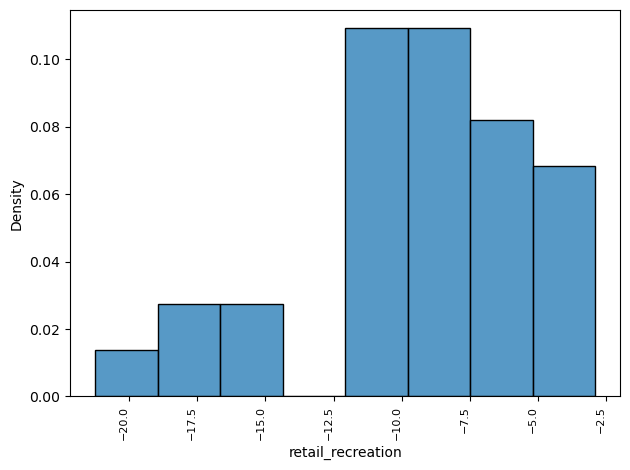

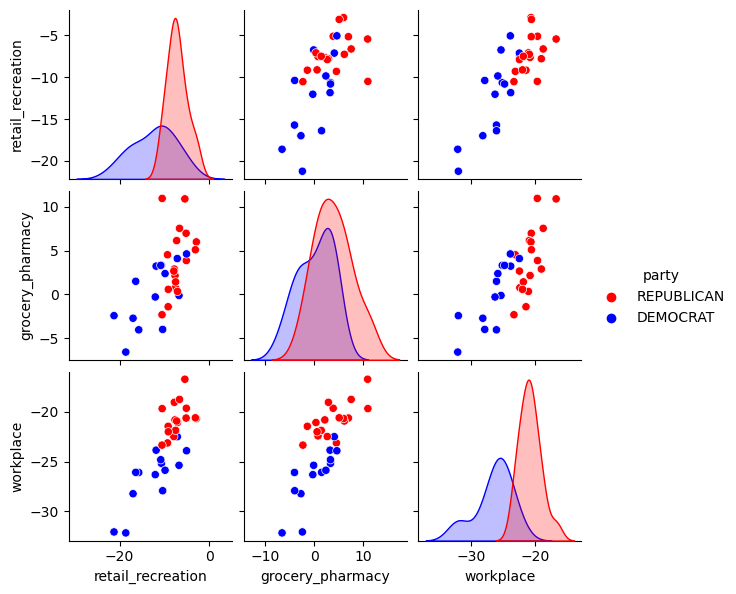

In [47]:
sns.histplot(means_by_state_with_party['retail_recreation'], stat='density')
plt.xticks(rotation=90, ha='right', fontsize=8)
plt.tight_layout()
plt.show();
sns.pairplot(
                means_by_state_with_party,
                hue='party',
                palette = {'REPUBLICAN':"red", "DEMOCRAT": "blue"}, 
                height=2)
plt.show();

In [48]:
# Create two new tables, each of which only contains a specific party (i.e. One table for Democrats winning counties only, one for republican winning counties.)
red_state_20 = mobility_party_20[mobility_party_20['party'] == 'REPUBLICAN']
blue_state_20 = mobility_party_20[mobility_party_20['party'] == 'DEMOCRAT']
red_state_20 = red_state_20[['retail_recreation','grocery_pharmacy','workplace','month']].groupby(by=['month'], as_index = False).mean()
blue_state_20 = blue_state_20[['retail_recreation','grocery_pharmacy','workplace','month']].groupby(by=['month'], as_index = False).mean()


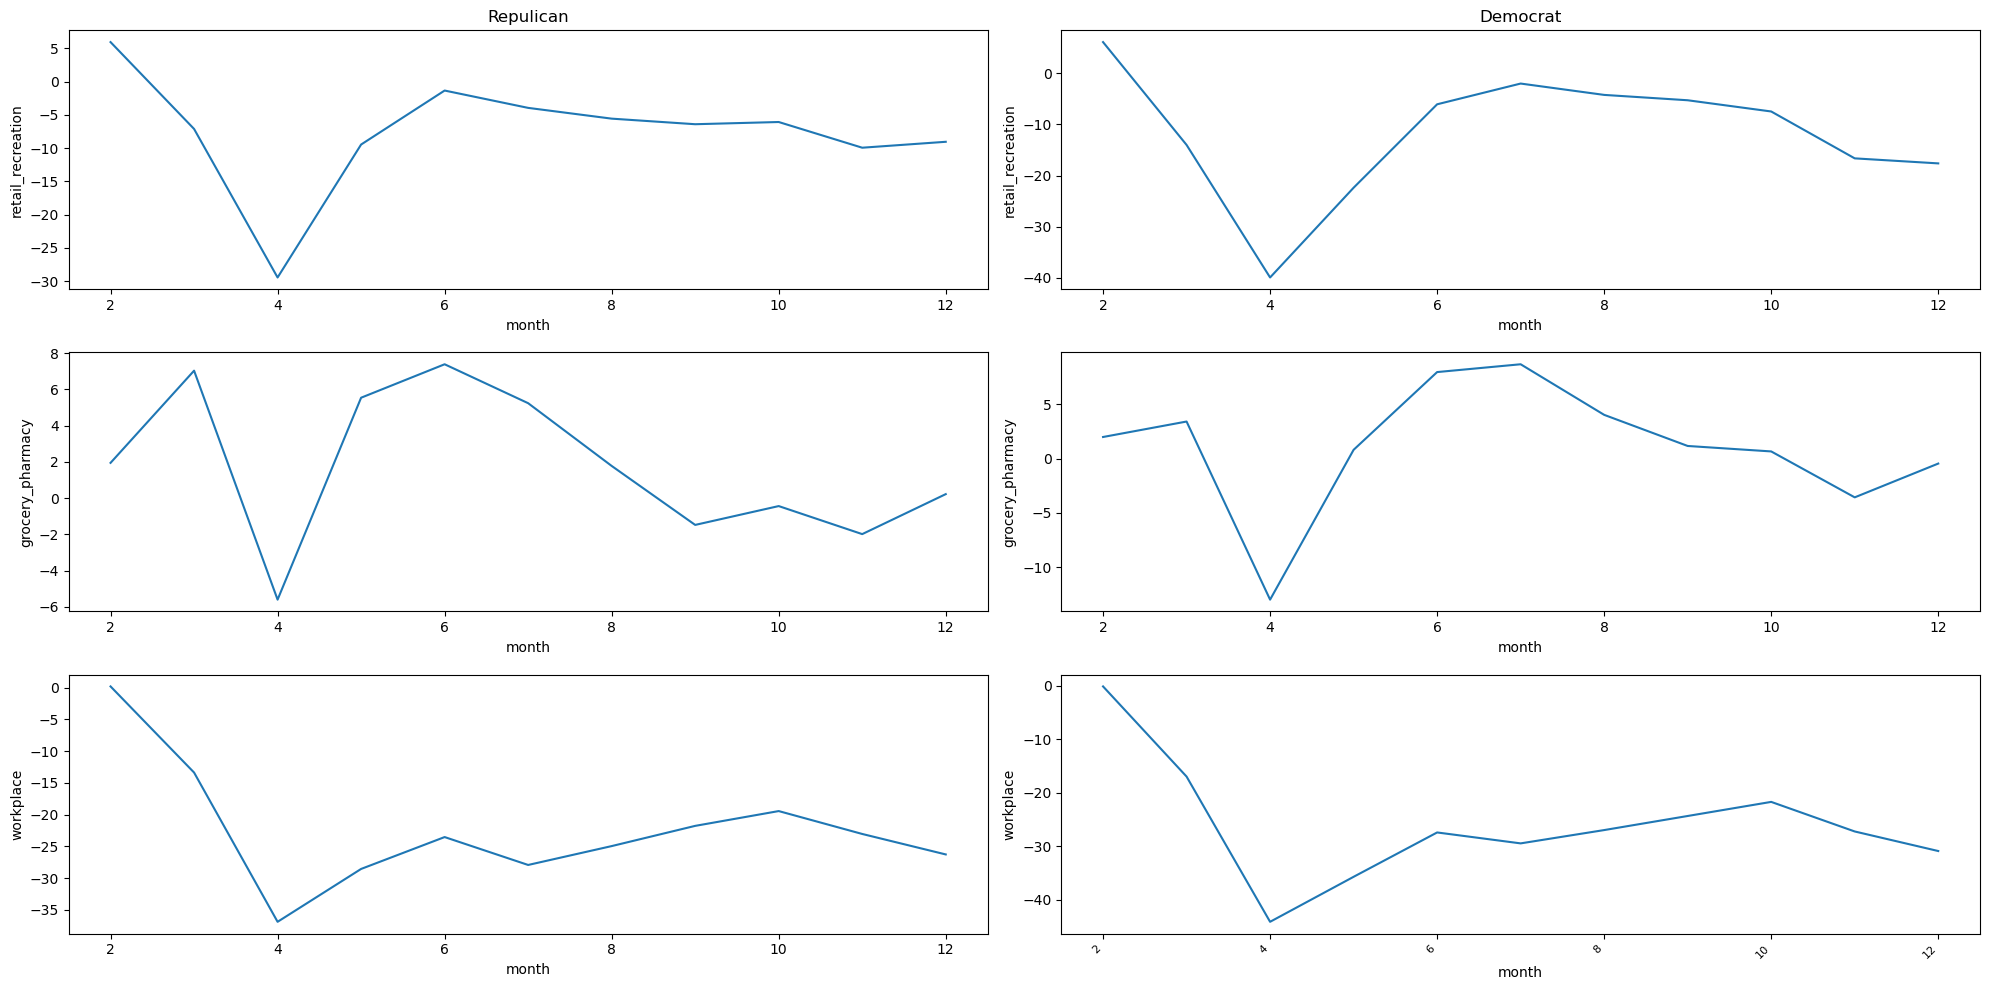

In [49]:
# Define the number of rows and columns for the subplots
nrows = 3
ncols = 2

red_cols = red_state_20
blue_cols = blue_state_20

totals_for_line = [red_cols, blue_cols]
# Create the figure and subplots
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10))

for i in range(2):
    for j in range(3):
        sns.lineplot(ax = axs[j,i], x = totals_for_line[i]['month'], 
                                    y = totals_for_line[i].iloc[:,j+1])
        if i == 0 and j == 0:
            axs[j,i].set_title('Repulican')
        elif i == 1 and j == 0:
            axs[j,i].set_title('Democrat')
        plt.xticks(rotation=45, ha='right', fontsize=8)
        plt.tight_layout()

# Set the overall title for the figure

# Show the plot
plt.show()

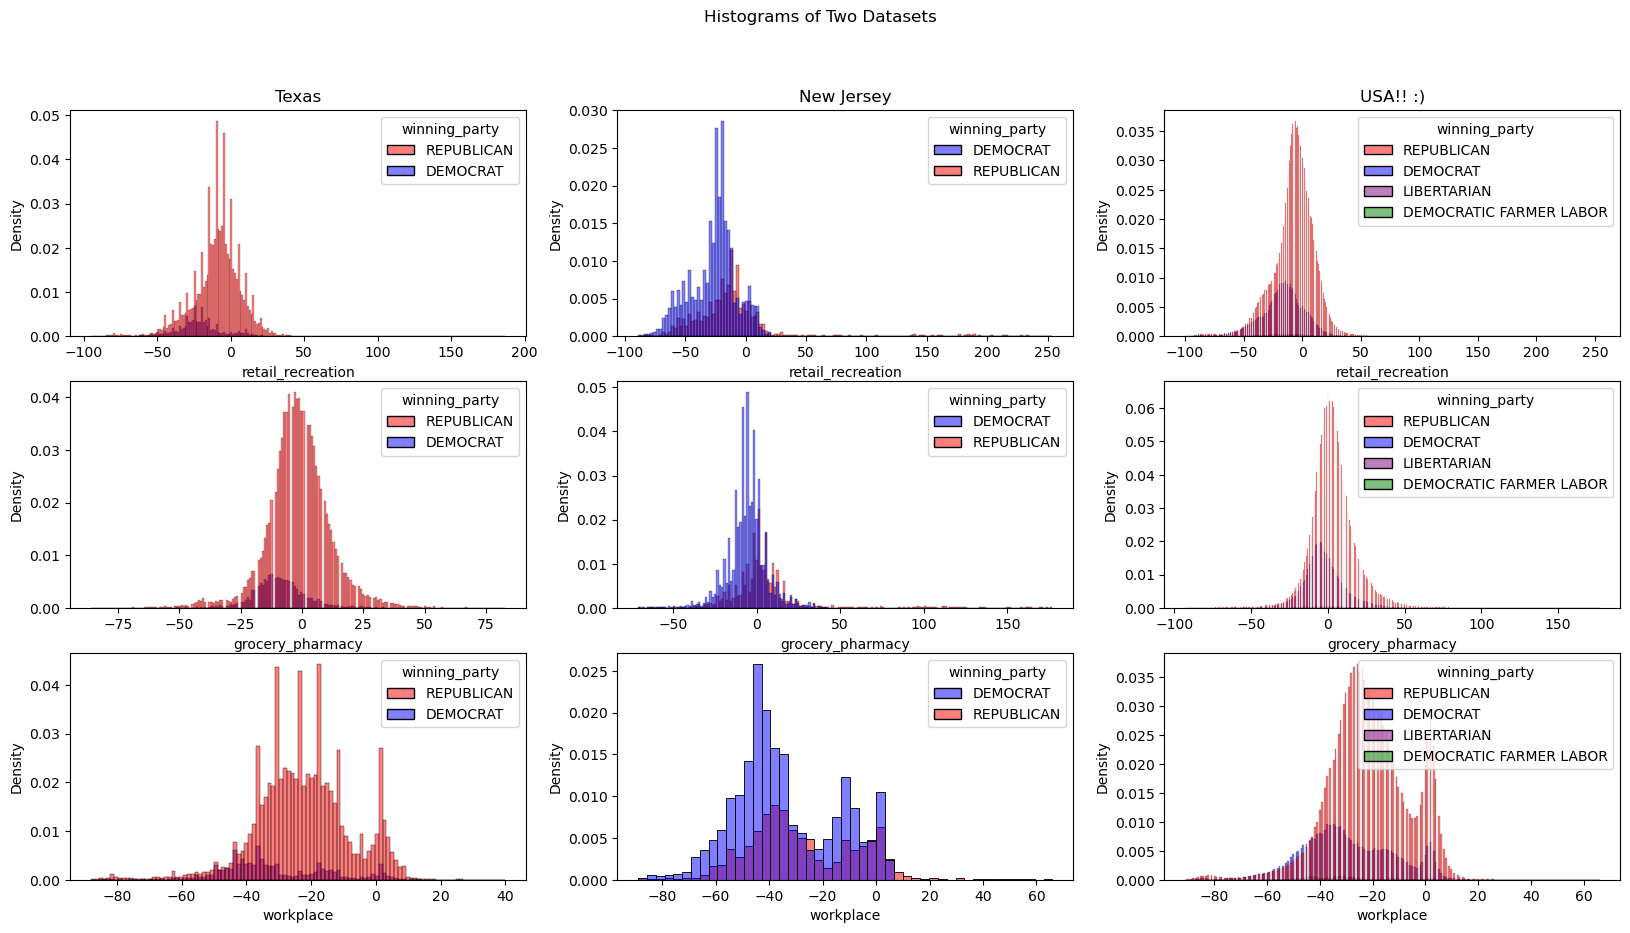

In [50]:
# Define the number of rows and columns for the subplots
nrows = 3
ncols = 3

texas_party_20 = mobility_party_20[mobility_party_20['state'] == 'TEXAS']
new_jersey_party_20 = mobility_party_20[mobility_party_20['state'] == 'NEW JERSEY']

texas_cols = texas_party_20.loc[:, 'retail_recreation':'winning_party']
new_jersey_cols = new_jersey_party_20.loc[:, 'retail_recreation':'winning_party']
usa_cols = mobility_party_20.loc[:, 'retail_recreation':'winning_party']

totals_for_hist = [texas_cols, new_jersey_cols, usa_cols]

# Create the figure and subplots
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10))

palette = {'REPUBLICAN':'red', 'DEMOCRAT':'blue', 'LIBERTARIAN':'purple', 'DEMOCRATIC FARMER LABOR':'green'}

for i in range(3):
    for j in range(3):
        for_hue = totals_for_hist[i]['winning_party']
        sns.histplot(ax=axs[j,i], x=totals_for_hist[i].iloc[:,j], stat='density', hue=for_hue, palette=palette)
        if i == 0 and j == 0:
            axs[j,i].set_title('Texas')
        elif i == 1 and j == 0:
            axs[j,i].set_title('New Jersey')
        elif i == 2 and j == 0:
            axs[j,i].set_title('USA!! :)')

# Set the overall title for the figure
fig.suptitle('Histograms of Two Datasets')

# Show the plot
plt.show()


### Question 2:

During the pandemic, will the changes in air traffic flying in Domestic(U.S.) affect the country's investment in the aviation industry?

**Scatter Plot: Compare U.S. Domestic Air Traffic & Government Construction Spending on Air**

In [51]:
trans_df = transportation_df(transportation)
trans_df.tail(3)

,Date,domes_traffic,domes_traffic_nonseason,air spending,inter traffic,air employment,hvm
909,10/01/2022,NaN,NaN,1.560000e+09,NaN,517300.0,NaN
910,11/01/2022,NaN,NaN,1.411000e+09,NaN,519300.0,NaN
911,12/01/2022,NaN,NaN,1.257000e+09,NaN,520500.0,NaN


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


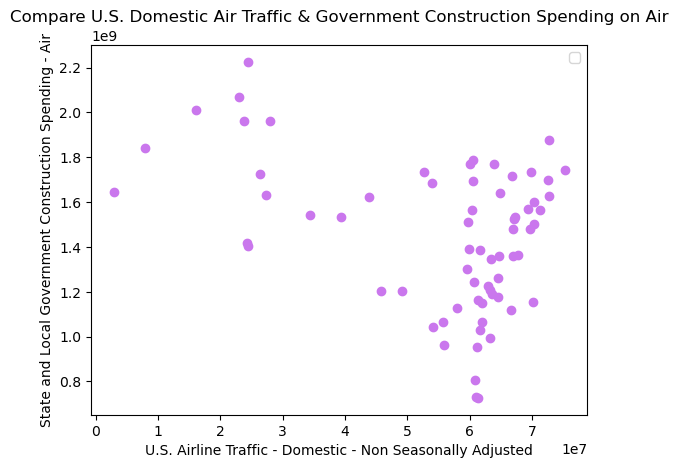

In [52]:

X = trans_df['domes_traffic_nonseason']
Y = trans_df['air spending']
#m, b = np.polyfit(X, Y, 1)
#Y_pred = m*X+b

plt.scatter(X, Y, color='#ca77ed')
#plt.plot(X, Y_pred, color='black', label='line of best fit')
plt.xlabel('U.S. Airline Traffic - Domestic - Non Seasonally Adjusted')
plt.ylabel('State and Local Government Construction Spending - Air')
plt.title('Compare U.S. Domestic Air Traffic & Government Construction Spending on Air')
plt.legend()
plt.show()

In order to observe whether domestic traffic（US） will affect the state and local government's construction investment in air, we use a scatter plot to observe the correlation between the two.
It seems difficult to see some kind of linear relationship if you directly observe the correlation between the two. 
However, changes in traffic may have a lagged effect on investment, so we intend to look at the correlation between traffic and investment of two months later.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


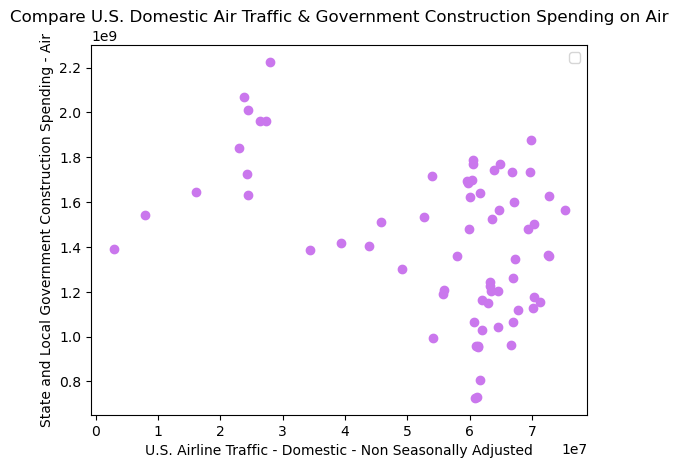

In [53]:
X = trans_df['domes_traffic_nonseason'].iloc[2: ]
Y = trans_df['air spending'].iloc[:-2]
#m, b = np.polyfit(X, Y, 1)
#Y_pred = m*X+b

plt.scatter(X, Y, color='#ca77ed')
#plt.plot(X, Y_pred, color='black', label='line of best fit')
plt.xlabel('U.S. Airline Traffic - Domestic - Non Seasonally Adjusted')
plt.ylabel('State and Local Government Construction Spending - Air')
plt.title('Compare U.S. Domestic Air Traffic & Government Construction Spending on Air')
plt.legend()
plt.show()

Because monthly domestic traffic may have a lag effect on government investment decisions, we observe the correlation between domestic traffic and government investment two months later, and find that there may be a linear relationship between the two variables.

``To see the domestic traffic of flight, seasonal and non_seasonsal variables have a strong corrlation which colse to 1. Thus, we may choise one of the two variables to work.``

**Observing 5 years of government investment in the transportation sector**

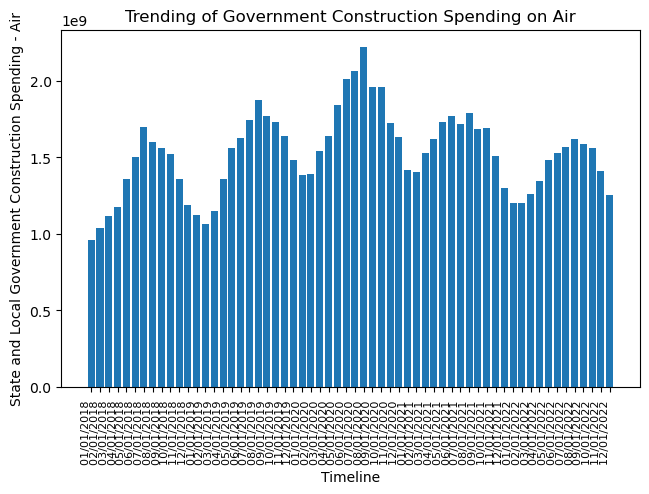

In [54]:
# use plt
# X: Contain data from 01/01/2018 to 12/01/2022
X = trans_df['Date'][-60: ]
Y = trans_df['air spending'][-60: ]

fig, ax = plt.subplots()
ax.bar(X, Y)
plt.xticks(rotation=90, ha='right', fontsize=8)
plt.tight_layout()
ax.set_title('Trending of Government Construction Spending on Air')
ax.set_xlabel('Timeline')
ax.set_ylabel('State and Local Government Construction Spending - Air')
plt.show()

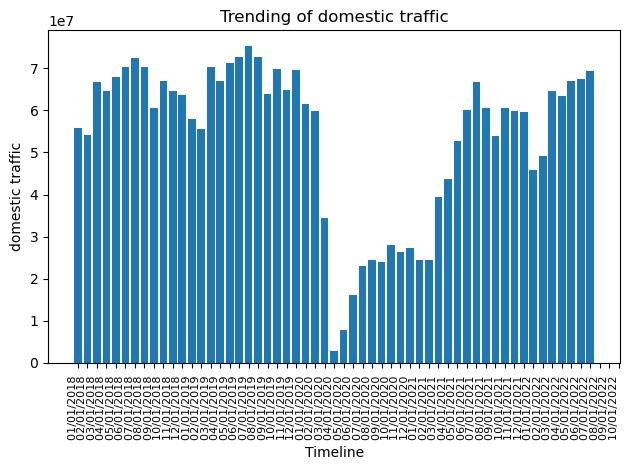

In [55]:
# X: Contain data from 01/01/2018 to 12/01/2022
X = trans_df['Date'][-60: ]
Y = trans_df['domes_traffic_nonseason'][-60: ]

fig, ax = plt.subplots()
ax.bar(X,Y)
ax.set_title('Trending of domestic traffic')
ax.set_xlabel('Timeline')
ax.set_ylabel('domestic traffic')
plt.xticks(rotation=90, ha='right', fontsize=8)
plt.tight_layout()
plt.show()

The minimum domestic traffic happened at 28-th month which start from 01/01/2018. So the timeline point to April 2020. This is due to the stay-at-home order issued by the United States in March 2020.

Vaccinated distribution in May 2022 falls off a cliff to the earliest vaccination levels.

If we look at the plot of "Distributed of Vaccine", the earliest data collection is December 2020, which indicates that the vaccine was developed successfully and is precisely in use. This will allow the spread of the epidemic to be contained, while the health of the general public is somehow protected. This will also affect the lifestyle changes of the population. We also see a precipitous drop in the number of people vaccinated in May 2022 to the earliest levels of vaccination, indicating that the vast majority of the population has been vaccinated and that the epidemic has been contained at the same time and that people's lives are gradually returning to pre-epidemic conditions. So, here are three important points in time:
    March 2020: major outbreak and lack of vaccine protection
    December 2020: vaccine developed and in large quantities
    May 2022: a precipitous decline in vaccination numbers, which signals the end of the pandemic.
    
So we have divided the timeline into 4 phases:
    Pre-pandemic (Before 2020.4)
    Pandemic-no vaccine (2020.04-2020.12)
    Pandemic-vaccine (2021.1-2022.5)
    Post-pandemic (After 2022.5)

Based on the results of data exploration, here, self define pandemic begins in April 2020 and ends in May 2022, for a total of 25 months.

In [56]:
# creat a categorical variable: 'Covid status' - Distinguish between the three conditions of a pandemic
trans_df_time = trans_df
trans_df_time['Date'] = pd.to_datetime(trans_df['Date'])
pandemic_start = pd.to_datetime('2020-04-01')
pandemic_end = pd.to_datetime('2022-05-31')

trans_df_time['Covid status'] = 'Before'  # initialize Covid status column with 0
trans_df_time.loc[(trans_df_time['Date'] >= pandemic_start) & (trans_df_time['Date'] <= pandemic_end), 'Covid status'] = 'Pandemic'
trans_df_time.loc[trans_df_time['Date'] > pandemic_end, 'Covid status'] = 'After'
trans_df_time.head(3)

,Date,domes_traffic,domes_traffic_nonseason,air spending,inter traffic,air employment,hvm,Covid status
780,2012-01-01,NaN,NaN,595000000.0,NaN,457900.0,NaN,Before
781,2012-02-01,NaN,NaN,577000000.0,NaN,457200.0,NaN,Before
782,2012-03-01,NaN,NaN,610000000.0,NaN,459100.0,NaN,Before


In [28]:
trans_df_time.groupby('Covid status').mean('air spending')

,domes_traffic,domes_traffic_nonseason,air spending,inter traffic,air employment
Covid status,,,,,
After,6.128500e+07,6.838500e+07,1.505714e+09,8.760000e+06,515514.285714
Before,6.428462e+07,6.377282e+07,1.035323e+09,9.178462e+06,473393.939394
Pandemic,4.139615e+07,4.136731e+07,1.643846e+09,4.252692e+06,449984.615385


**Visualize for categorical variable**

Text(0.5, 1.0, 'Mean of State and Local Government Construction Spending - Air in different period')

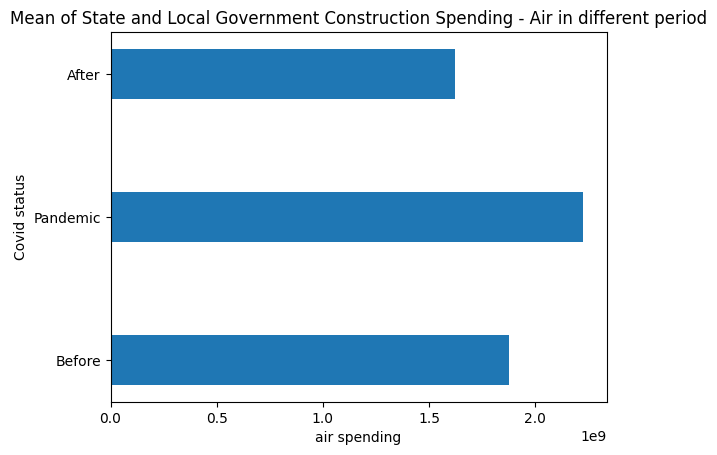

In [29]:
plt.barh(trans_df_time['Covid status'], trans_df_time['air spending'], height = 0.35)
plt.xlabel('air spending')
plt.ylabel('Covid status')
plt.title('Mean of State and Local Government Construction Spending - Air in different period')

In [57]:
trans_df_select = trans_df[trans_df['air spending'] <= 3500000000]
trans_df

,Date,domes_traffic,domes_traffic_nonseason,air spending,inter traffic,air employment,hvm,Covid status
780,2012-01-01,NaN,NaN,5.950000e+08,NaN,457900.0,NaN,Before
781,2012-02-01,NaN,NaN,5.770000e+08,NaN,457200.0,NaN,Before
782,2012-03-01,NaN,NaN,6.100000e+08,NaN,459100.0,NaN,Before
783,2012-04-01,NaN,NaN,6.510000e+08,NaN,459800.0,NaN,Before
784,2012-05-01,NaN,NaN,7.660000e+08,NaN,461500.0,NaN,Before
...,...,...,...,...,...,...,...,...
907,2022-08-01,NaN,NaN,1.622000e+09,NaN,514500.0,NaN,After
908,2022-09-01,NaN,NaN,1.590000e+09,NaN,514100.0,NaN,After
909,2022-10-01,NaN,NaN,1.560000e+09,NaN,517300.0,NaN,After
910,2022-11-01,NaN,NaN,1.411000e+09,NaN,519300.0,NaN,After


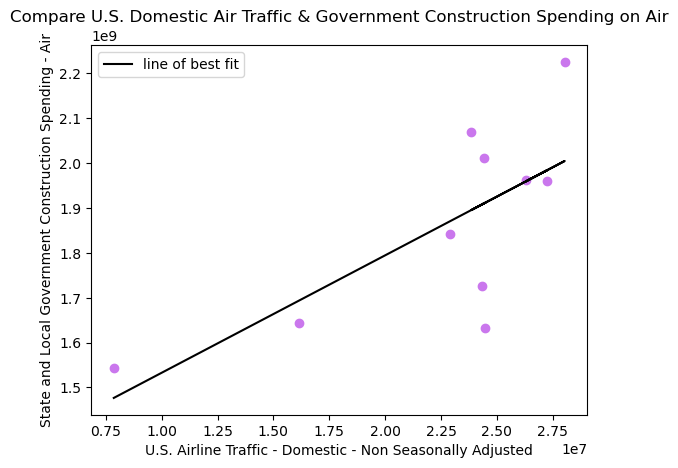

In [58]:
# X = trans_df['domes_traffic_nonseason'].iloc[2: ]
# Y = trans_df['air spending'].iloc[:-2]

trans_df_select = trans_df[trans_df['domes_traffic_nonseason'] <= 35000000]
X = trans_df_select['domes_traffic_nonseason'].iloc[2: ]
Y = trans_df_select['air spending'].iloc[:-2]
m, b = np.polyfit(X, Y, 1)
Y_pred = m*X+b

plt.scatter(X, Y, color='#ca77ed')
plt.plot(X, Y_pred, color='black', label='line of best fit')
plt.xlabel('U.S. Airline Traffic - Domestic - Non Seasonally Adjusted')
plt.ylabel('State and Local Government Construction Spending - Air')
plt.title('Compare U.S. Domestic Air Traffic & Government Construction Spending on Air')
plt.legend()
plt.show()



## Question 1: GLM/Non-Parametric

In [33]:
# import libraries and packages
import numpy as np
import pandas as pd
import scipy.stats as stats
import sklearn as sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression 
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from pymc3 import *
import pymc3 as pm
from sklearn.metrics import accuracy_score
from sqlalchemy import create_engine
from pandasql import sqldf

## Merge the election data with the mobility data (2020)

In [34]:
#276914 rows × 7 columns,   [state	county	date    retail_recreation	grocery_pharmacy	workplace	winner]
sql_mobility_20 = '''SELECT mobility_20.*, w.party_detailed as winner 
                    FROM mobility_20 JOIN winning_county as w 
                    ON mobility_20.county = w.county_name 
                    AND mobility_20.state = w.state;'''
sql_mobility_20 = sqldf(sql_mobility_20)

#276914 rows × 10 columns, 
#[state	county	date	retail_recreation	grocery_pharmacy	workplace	winner	DEMOCRAT_Percent	REPUBLICAN_Percent	LIBERTARIAN_Percent]
party_20 = '''SELECT sql_mobility_20.*, s.DEMOCRAT_vote_share AS DEMOCRAT_Percent, s.REPUBLICAN_vote_share 
            AS REPUBLICAN_Percent, s.LIBERTARIAN_vote_share AS LIBERTARIAN_Percent 
            FROM sql_mobility_20 JOIN senate_2020 as s ON sql_mobility_20.county = s.county_name 
            AND sql_mobility_20.state = s.state;'''

party_20 = sqldf(party_20)
party_20['winner_binary'] = party_20['winner'].apply(lambda x: 1 if x == 'DEMOCRAT' else 0)

/tmp/ipykernel_237/122159975.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  party_20['county_party_binary'] = party_20['winning_party'].map(party_map)
/tmp/ipykernel_237/122159975.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  party_20['state_party_binary'] = party_20['party'].map(party_map)


# Import 2022 Senate Election 

### Only include California, Illinois and Kansas due to the lack of data resource.

In [35]:
# Seneate election result in California
# Source: https://www.sos.ca.gov/elections/prior-elections/statewide-election-results/general-election-nov-8-2022/statement-vote
cali_22_origin = pd.read_csv('california_senate.csv').iloc[:,:3].dropna()
cali_22_origin = cali_22_origin.rename(columns={'Unnamed: 0': "County", 'Alex Padilla':"Democrat", 
                                                        'Mark P. Meuser': "Republican"})
cali_22_origin['County'] = cali_22_origin['County'].str.upper()

# Clean the dataframe and remove the rows with "PERCENT" and concat it to its corresponding county.

# Create a dataframe only contains counties' data
only_county = cali_22_origin.drop(cali_22_origin[cali_22_origin['County'].str.contains('PERCENT', case = False)].index)
only_county = only_county.drop(only_county[only_county['County'].str.contains('STATE TOTAL', case = False)].index)
only_county = only_county.reset_index(drop = True)
only_county['Democrat'] = only_county['Democrat'].str.replace(',','').astype(int)
only_county['Republican'] = only_county['Republican'].str.replace(',','').astype(int)

# Create a dataframe only contains the percentage data
percent = cali_22_origin[cali_22_origin["County" ] == '  PERCENT'].drop(cali_22_origin.index[-1]).drop(columns = {'County'})
percent['DEMOCRAT_Percent'] = percent['Democrat'].str.replace('%','').astype(float)/100
percent['REPUBLICAN_Percent'] = percent['Republican'].str.replace('%','').astype(float)/100
percent = percent.reset_index(drop = True)

# Concat the data into new cali_22 dataframe
cali_22 = pd.concat([only_county, percent], axis = 1)
cali_22 = cali_22.iloc[:, [0,5,6]]
cali_22['winner'] = cali_22.apply(lambda row: 'DEMOCRAT' if row['DEMOCRAT_Percent'] > row['REPUBLICAN_Percent'] else 'REPUBLICAN', axis=1)
cali_22['winner_binary'] = cali_22.apply(lambda row: 1 if row['DEMOCRAT_Percent'] > row['REPUBLICAN_Percent'] else 0, axis=1)

In [ ]:
# Define a function to determine the winner
def get_winner(row):
    if row['DEMOCRAT_Percent'] > row['REPUBLICAN_Percent'] and row['DEMOCRAT_Percent'] > row['LIBERTARIAN_Percent']:
        return 'DEMOCRAT'
    elif row['REPUBLICAN_Percent'] > row['DEMOCRAT_Percent'] and row['REPUBLICAN_Percent'] > row['LIBERTARIAN_Percent']:
        return 'REPUBLICAN'

# Define a function to determine the winner_binary
def get_winner_binary(row):
    if row['DEMOCRAT_Percent'] > row['REPUBLICAN_Percent'] and row['DEMOCRAT_Percent'] > row['LIBERTARIAN_Percent']:
        return 1
    elif row['REPUBLICAN_Percent'] > row['DEMOCRAT_Percent'] and row['REPUBLICAN_Percent'] > row['LIBERTARIAN_Percent']:
        return 0

In [ ]:
# Senate election result in Illinois
# Source: https://www.elections.il.gov/electionoperations/votetotalsearch.aspx
illinois_22 = pd.read_csv('Illinois_22.csv')

# Drop unnecessary Columns and them by county + Party
illinois_22 = illinois_22[['JurisName','PartyName', 'VoteCount']]
illinois_22 = illinois_22.groupby(['JurisName', 'PartyName'], as_index = False).sum()
illinois_22 = illinois_22.rename(columns = {'JurisName': "County", 'PartyName': "Party", 'VoteCount':"Vote"})
illinois_22['Party'] = illinois_22['Party'].str.upper()
illinois_22 = illinois_22.drop(illinois_22[illinois_22['Party'].str.contains('NONPARTISAN')].index)
illinois_22 = illinois_22.drop(illinois_22[illinois_22['Party'].str.contains('NON-PARTISAN')].index)
illinois_22_origin = illinois_22.replace('DEMOCRATIC', 'DEMOCRAT')

# Calculate the total votes per county
county_totals = illinois_22_origin.groupby('County')['Vote'].sum()

# Pivot the table to get the vote counts for each party in each county
df_pivot = illinois_22_origin.pivot_table(index='County', columns='Party', values='Vote')

# Calculate the vote share percentages for each party in each county
df_percent = df_pivot.div(county_totals, axis=0) 

# Rename the columns to match the desired format
df_percent.columns = [party + '_Percent' for party in df_percent.columns]

# Reset the index to turn the County column into a regular column
illinois_22 = df_percent.reset_index()

# Apply the function to each row and create a new column called "winner"
illinois_22['winner'] = illinois_22.apply(get_winner, axis=1)
illinois_22['winner_binary'] = illinois_22.apply(get_winner_binary, axis=1)

In [ ]:
# Import 2022 Kansas state Senate election results
# Source: https://sos.ks.gov/elections/elections-results.html
kansas_22_origin = pd.read_csv('kansas_22.csv')
kansas_22_origin = kansas_22_origin[['County','Party','Votes']].groupby(['County','Party'],as_index = False).sum()
kansas_22_origin["Party"] = kansas_22_origin["Party"].str.upper()
kansas_22_origin = kansas_22_origin.replace('DEMOCRATIC', 'DEMOCRAT')

# Calculate the total votes per county
county_totals = kansas_22_origin.groupby('County')['Votes'].sum()

# Pivot the table to get the vote counts for each party in each county
df_pivot = kansas_22_origin.pivot_table(index='County', columns='Party', values='Votes')

# Calculate the vote share percentages for each party in each county
df_percent = df_pivot.div(county_totals, axis=0) 

# Rename the columns to match the desired format
df_percent.columns = [party + '_Percent' for party in df_percent.columns]

# Reset the index to turn the County column into a regular column
kansas_22 = df_percent.reset_index()
kansas_22['County'] = kansas_22['County'].str.upper()
kansas_22['winner'] = kansas_22.apply(get_winner, axis=1)
kansas_22['winner_binary'] = kansas_22.apply(get_winner_binary, axis=1)

# Merge election data with mobility data

### Only California, Illinois and Kansas are selected.

In [ ]:
#13942 rows × 7 columns
#[state	county	date	retail_recreation	grocery_pharmacy	workplace	winner_binary]
cali_22_binary = '''SELECT mobility_22.*, cal.winner_binary 
                        FROM mobility_22 JOIN cali_22 as cal 
                            ON mobility_22.county = cal.County 
                                WHERE mobility_22.state = 'CALIFORNIA';'''
cali_22_binary = sqldf(cali_22_binary)

#10215 rows × 7 columns
#[state	county	date	retail_recreation	grocery_pharmacy	workplace	winner_binary]
illinois_22_binary = '''SELECT mobility_22.*, illi.winner_binary 
                            FROM mobility_22 JOIN illinois_22 as illi 
                                ON mobility_22.county = illi.County 
                                    WHERE mobility_22.state = 'ILLINOIS';'''
illinois_22_binary = sqldf(illinois_22_binary)

#3669 rows × 7 columns
#[state	county	date	retail_recreation	grocery_pharmacy	workplace	winner_binary]
kansas_22_binary = '''SELECT mobility_22.*, kan.winner_binary 
                        FROM mobility_22 JOIN kansas_22 as kan  
                            ON mobility_22.county = kan.County 
                                WHERE mobility_22.state = 'KANSAS';'''
kansas_22_binary = sqldf(kansas_22_binary)


# GLM

## Frequentist

### Train the frequentist GLM model based on the data in 2020

In [ ]:
# Train logistic regression on 2020 dataset 

X = party_20[['retail_recreation', 'grocery_pharmacy', 'workplace']]
y = party_20['winner_binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf_fre = LogisticRegression() #set the threshold 
clf_fre.fit(X_train, y_train)

# Calculate the accruacy based on the test set
score = clf_fre.score(X_test, y_test)
print(f'Test Accuracy for 2020 dateset: {score}')
print(f'Coefficients for 2020 dataset: {clf_fre.coef_}')
print(f'Intercept for 2020 dateset: {clf_fre.intercept_}')

Test Accuracy for 2020 dateset: 0.771879457595291
Coefficients for 2020 dataset: [[-0.01226893 -0.0107064  -0.01822611]]
Intercept for 2020 dateset: [-1.81501736]


### Frequentist Prediction of 2022 senate election and accuracy

In [ ]:
# Define the function to predict the election in 2022
def predict_frequen(df):
    df_predict = df[['retail_recreation', 'grocery_pharmacy', 'workplace']]
    df_result = df['winner_binary']
    accuracy = clf_fre.score(df_predict, df_result)
    return accuracy

# Predict California senate election in 2022
cali_predict = predict_frequen(cali_22_binary)
print(f'Accuracy for California 2022 senate predictions: {cali_predict}')

# Predict Illinois senate election in 2022
illinois_predict = predict_frequen(illinois_22_binary)
print(f'Accuracy for Illinois 2022 senate predictions: {illinois_predict}')

# Predict Kansas senate election in 2022
kansas_predict = predict_frequen(kansas_22_binary)
print(f'Accuracy for Kansas 2022 senate predictions: {kansas_predict}')

Accuracy for California 2022 senate predictions: 0.479845072442978
Accuracy for Illinois 2022 senate predictions: 0.7439060205580029
Accuracy for Kansas 2022 senate predictions: 0.9168710820387026


### 

## Bayesian

### Train the Bayesian GLM model based on the data in 2020

In [ ]:
# #1. Take a naive Prior -> Bernoulli(p) 
#     # f() = p^k * (1 - p)^k
# #2. Likelihood -> Bernoulli(p)
# #3. Inverse Link -> Sigmoid 

# #Density of Bernoulli(p) is p 
with pm.Model() as model:

    # Prior distribution of X
    rr_theta = pm.Uniform('rr_theta', lower=-100, upper=100)
    gp_theta = pm.Uniform('gp_theta', lower=-100, upper=100)
    wp_theta = pm.Uniform('wp_theta', lower=-100, upper=100)
    intercept = pm.Normal('intercept', mu=0, sigma=1)

    p = intercept + rr_theta*party_20['retail_recreation'] + gp_theta*party_20['grocery_pharmacy'] + wp_theta*party_20['workplace']
    # Likelihood Distribution 
    Y_obs = pm.Bernoulli('Y_obs', p=pm.math.invlogit(p), observed=party_20['winner_binary'])

    trace = pm.sample(1000,target_accept = 0.9)

pm.summary(trace)

/var/folders/jh/ybgr17351dxgmgfbv1j4tv980000gn/T/ipykernel_70523/2741406469.py:19: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1000,target_accept = 0.9)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, wp_theta, gp_theta, rr_theta]


/Users/ash_feng/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ash_feng/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ash_feng/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 394 seconds.
There were 905 divergences after tuning. Increase `target_accept` or reparameterize.
There were 944 divergences after tuning. Increase `target_accept` or reparameterize.
There were 764 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.772, but should be close to 0.9.

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-0.224,0.731,-0.812,0.988,0.364,0.279,4.0,4.0,4.26
rr_theta,-20.532,28.707,-43.286,28.777,14.296,10.946,4.0,11.0,4.03
gp_theta,-25.398,16.727,-40.101,2.694,8.330,6.378,4.0,4.0,5.00
wp_theta,-1.846,38.362,-41.593,46.293,19.104,14.628,4.0,11.0,4.03


In [ ]:
theta = [np.mean(trace['rr_theta']),np.mean(trace['gp_theta']), np.mean(trace['wp_theta']), np.mean(trace['intercept'])]

# Set up the sigmoid function
def sigmoid(x, theta):
    retail_recreation = x['retail_recreation'] * theta[0]
    grocery_pharmacy = x['grocery_pharmacy'] * theta[1]
    workplace = x['workplace'] * theta[2]
    return 1/(1+np.e**(-1*(retail_recreation + grocery_pharmacy + workplace + theta[-1])))

# Function for outputting the accuracy of Bayesian GLM
def predict_bayesian(df, result):
    prediction = sigmoid(df, theta)
    prediction = prediction
    prediction = np.where(prediction >= 0.5, 1, 0)  
    accuracy = np.mean(prediction == result)
    print('Accuracy:', accuracy)
    return accuracy

In [ ]:
# Predict California senate election in 2022

cali_predict = predict_bayesian(cali_22_binary[['retail_recreation', 'grocery_pharmacy', 'workplace']]
                                , cali_22_binary['winner_binary'])

Accuracy: 0.6212164682255057


In [ ]:
# Predict Illinois senate election in 2022

illinois_predict = predict_bayesian(illinois_22_binary[['retail_recreation', 'grocery_pharmacy', 'workplace']]
                                , illinois_22_binary['winner_binary'])

Accuracy: 0.6624571708272149


## Neural Network

### Train the NN model based on the data in 2020

In [ ]:
# Apply Neural Network to predict the vote share
X = party_20[['retail_recreation', 'grocery_pharmacy', 'workplace']]
y = party_20['winner_binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf_nn = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=5, activation='logistic', 
                    solver='adam', verbose=True)

# Train the Model
clf_nn.fit(X_train, y_train)

y_pred = clf_nn.predict(X_test)
accuracy_score(y_test, y_pred)

Iteration 1, loss = 0.49835060
Iteration 2, loss = 0.48523689
Iteration 3, loss = 0.48186777
Iteration 4, loss = 0.48017580
Iteration 5, loss = 0.47914328


/Users/ash_feng/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(


0.786396547677085

In [ ]:
# Define the function to predict the election in 2022
def predict_nn(df):
    df_predict = df[['retail_recreation', 'grocery_pharmacy', 'workplace']]
    df_result = df['winner_binary']
    accuracy = clf_nn.score(df_predict, df_result)
    print('Accuracy:', accuracy)
    return accuracy

### Neural Network Prediction of 2022 senate election and accuracy

In [ ]:
# Predict California senate election in 2022

cali_predict = predict_nn(cali_22_binary)

Accuracy: 0.5624731028546837


In [ ]:
# Predict Illinois senate election in 2022

illinois_predict = predict_nn(illinois_22_binary)

Accuracy: 0.748898678414097


In [ ]:
# Predict Kansas senate election in 2022

kansas_predict = predict_nn(kansas_22_binary)

Accuracy: 0.9138729899155084


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d8cd6271-edcb-448c-8086-f68db163b0b9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>

## Question 2: Causal Inference

In [59]:
# reset data with 2 monthes lag of air spending
trans_df.dropna(inplace= True)
temp_list = trans_df['air spending'].iloc[2: ].values
temp_list = temp_list.tolist()
temp_list= np.append(temp_list, ['nan', 'nan'])
#temp_list = np.asarray(temp_list)
trans_df['air spending_lag 2 mons'] = temp_list
trans_df_reset = trans_df.iloc[:-2]
trans_df_reset = trans_df_reset.apply(pd.to_numeric, errors='coerce')
trans_df_reset['Date']= trans_df['Date']

In order to see whether domestic traffic of air has a causal inference on local government investment on air, we will select the domestic traffic of air variable as the treatment. Since domestic traffic of air is a continuous variable, in order to simplify the analysis of Causal Inference, we transform this continuous variable into a dummy variable by an easy method. Since domestic traffic has a very significant difference during the pandemic, we transform domestic traffic into a dummy variable. We set the treatment "1" for the time interval when domestic traffic decreases significantly and the control "0" for the normal traffic during the normal time period.The time period for this treatment is March 2020 - March 2021 as seen in the EDA analysis above.(March 2020 Began to decline significantly and reached lowest peak in April 2020).


In [63]:
trans_df_time = trans_df_reset
trans_df_time['Date'] = pd.to_datetime(trans_df['Date'])
pandemic_start = pd.to_datetime('2020-03-01')
pandemic_end = pd.to_datetime('2021-03-31')

trans_df_time['treatment'] = 0  # initialize Covid status column with 0
trans_df_time.loc[(trans_df_time['Date'] >= pandemic_start) & (trans_df_time['Date'] <= pandemic_end), 'treatment'] = 1
trans_df = trans_df_time
trans_df.columns

Index(['Date', 'domes_traffic', 'domes_traffic_nonseason', 'air spending',
       'inter traffic', 'air employment', 'hvm', 'Covid status',
       'air spending_lag 2 mons', 'treatment'],
      dtype='object')

In [64]:
trans_df_time = trans_df_reset
trans_df_time['Date'] = pd.to_datetime(trans_df_reset['Date'])
pandemic_start = pd.to_datetime('2020-03-01')
pandemic_end = pd.to_datetime('2021-03-31')

trans_df_time['treatment'] = 0  # initialize Covid status column with 0
trans_df_time.loc[(trans_df_time['Date'] >= pandemic_start) & (trans_df_time['Date'] <= pandemic_end), 'treatment'] = 1
trans_df_reset = trans_df_time
trans_df_reset.columns

Index(['Date', 'domes_traffic', 'domes_traffic_nonseason', 'air spending',
       'inter traffic', 'air employment', 'hvm', 'Covid status',
       'air spending_lag 2 mons', 'treatment'],
      dtype='object')

**Some functions for Outcome Regression**

In [66]:
# Technique： Outcome Regression
def fit_OLS_model(df, target_variable, explanatory_variables, intercept = False):
    """
    Fits an OLS model from data.
    
    Inputs:
        df: pandas DataFrame
        target_variable: string, name of the target variable
        explanatory_variables: list of strings, names of the explanatory variables
        intercept: bool, if True add intercept term
    Outputs:
        fitted_model: model containing OLS regression results
    """
    
    target = df[target_variable]
    inputs = df[explanatory_variables]
    if intercept:
        inputs = sm.add_constant(inputs)
    
    fitted_model = sm.OLS(target, inputs).fit()
    return(fitted_model)

def mean_squared_error(true_vals, predicted_vals):
    """
    Return the mean squared error（MSE）
    
    Inputs:
        true_vals: array of true labels
        predicted_vals: array labels predicted from the data
    Output:
        float, mean squared error of the predicted values
    """
    return np.mean((true_vals - predicted_vals) ** 2)

**Fitting our model (multiple confounders)**

Confounders: 'inter traffic', 'air employment'

In [67]:
full_linear_model = fit_OLS_model(trans_df_reset, 'air spending_lag 2 mons', ['treatment', 'inter traffic', 'hvm'])
print(full_linear_model.summary())

                                   OLS Regression Results                                   
Dep. Variable:     air spending_lag 2 mons   R-squared (uncentered):                   0.980
Model:                                 OLS   Adj. R-squared (uncentered):              0.979
Method:                      Least Squares   F-statistic:                              738.2
Date:                     Mon, 08 May 2023   Prob (F-statistic):                    2.90e-38
Time:                             14:16:58   Log-Likelihood:                         -991.07
No. Observations:                       48   AIC:                                      1988.
Df Residuals:                           45   BIC:                                      1994.
Df Model:                                3                                                  
Covariance Type:                 nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025 

**Bootstrapped estimates of the ATE**

In [68]:
# Bootstrapped estimates of the ATE
def draw_tau_hat(data=trans_df_reset, random_state=None):
    """Returns a single bootstrapped estimate of the ATE.
    
    Inputs:
        data: DataFrame of observed data
        random_state: integer to help standardize sampling output 
    Output:
        float, estimated average treatment effect
    """
    sample = data.sample(n=data.shape[0], random_state=random_state, replace=True) 
    fit_model = fit_OLS_model(sample, 'air spending_lag 2 mons', ['treatment', 'inter traffic'])
    estimated_ate = fit_model.params[0]
    return estimated_ate

def get_bootstrapped_ate(data=trans_df_reset, n=1000):
    """Returns n bootstrapped estimates of the ATE.
    
    Inputs:
        data: DataFrame of observed data
        n: number of bootstrapped estimates we would like to return
    Output:
        list of estimated average treatment effects
    """
    estimates = []
    for i in np.arange(n):
        estimate = draw_tau_hat(data=trans_df_reset)
        estimates.append(estimate)
    return estimates

In [69]:
ates = get_bootstrapped_ate(trans_df_reset, 1000)
confidence_interval = [np.percentile(ates, 2.5), 
                       np.percentile(ates, 97.5)]
print(f"Our 95% confidence interval ranges from {np.round(confidence_interval[0])} to {np.round(confidence_interval[1])}")

Our 95% confidence interval ranges from 1208489016.0 to 1711654850.0


**Try Inverse Propensity Weighting method**

In [70]:
X = trans_df_reset[['inter traffic','hvm']].values
treatment = trans_df_reset['treatment'].values
outcome = trans_df_reset['air spending'].values

#logistic regression model
lr = LR(penalty = 'none', max_iter = 200, random_state =0)        
lr_fitted = lr.fit(X,treatment)
# Compute propensity scores: e_hat
trans_df_reset['ipw score'] = lr.predict_proba(X)[:, 1]
# Trimming our propensities
trimmed = trans_df_reset[trans_df_reset['ipw score']>=0.01]
trimmed = trimmed[trimmed['ipw score'] <=0.99]
trimmed


#Estimate treatment effect accounting for propensity.
def estimate_treatment_effect(trimmed):
    treatment = trimmed['treatment'].values
    outcome = trimmed['air spending'].values
    e_hat = trimmed['ipw score'].values
    # calculate the tao_hat with the formula given
    tao_hat = np.average((treatment * outcome)/e_hat - ((1-treatment)* outcome)/(1-e_hat))
    return tao_hat


treatment_effect = estimate_treatment_effect(trimmed)
print(f"Estimated average treatment effect(ATE): {treatment_effect:.4f}")

Estimated average treatment effect(ATE): 391177611.8882


/Users/ash_feng/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


**Bootstrapped estimates of the ATE of IPW method**

In [71]:
# Bootstrapped estimates of the ATE of IPW method
def draw_tau_hat_ipw(data=trimmed, random_state=None):
    """Returns a single bootstrapped estimate of the ATE for IPW method.
    
    Inputs:
        data: DataFrame of trimmed data of IPW
        random_state: integer to help standardize sampling output  
    Output:
        float, estimated average treatment effect for IPW
    """
    sample = data.sample(n=data.shape[0], random_state=random_state, replace=True) 
    return estimate_treatment_effect(sample)

def get_bootstrapped_ate_ipw(data= trimmed, n=1000):
    """Returns n bootstrapped estimates of the ATE.
    
    Inputs:
        data: DataFrame of trimmed data of IPW
        n: number of bootstrapped estimates we would like to return
    Output:
        list of estimated average treatment effects
    """
    estimates = []
    for i in np.arange(n):
        estimate = draw_tau_hat_ipw(data= trimmed)
        estimates.append(estimate)
    return estimates

In [72]:
ates_ipw = get_bootstrapped_ate_ipw(trimmed, 2000)
confidence_interval = [np.percentile(ates_ipw, 2.5), 
                       np.percentile(ates_ipw, 97.5)]
print(f"Our 95% confidence interval ranges of IPW method from {np.round(confidence_interval[0])} to {np.round(confidence_interval[1])}")

Our 95% confidence interval ranges of IPW method from -659454406.0 to 1588289256.0
